In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

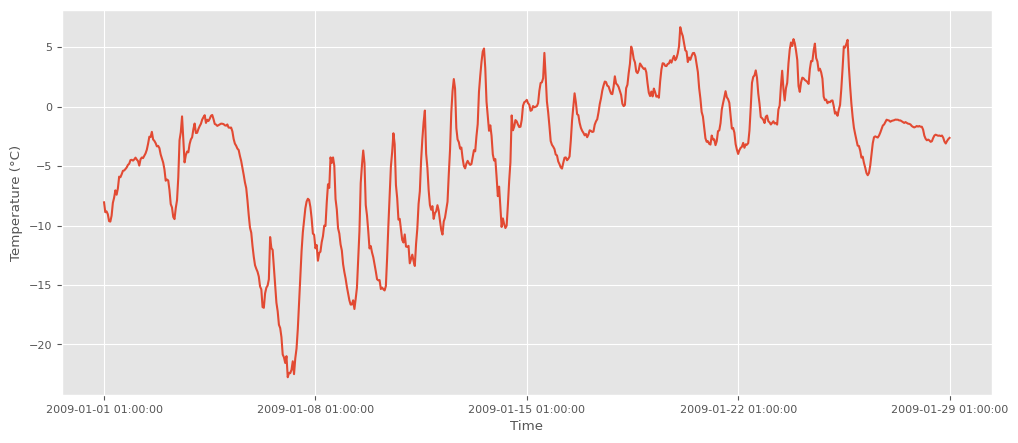

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

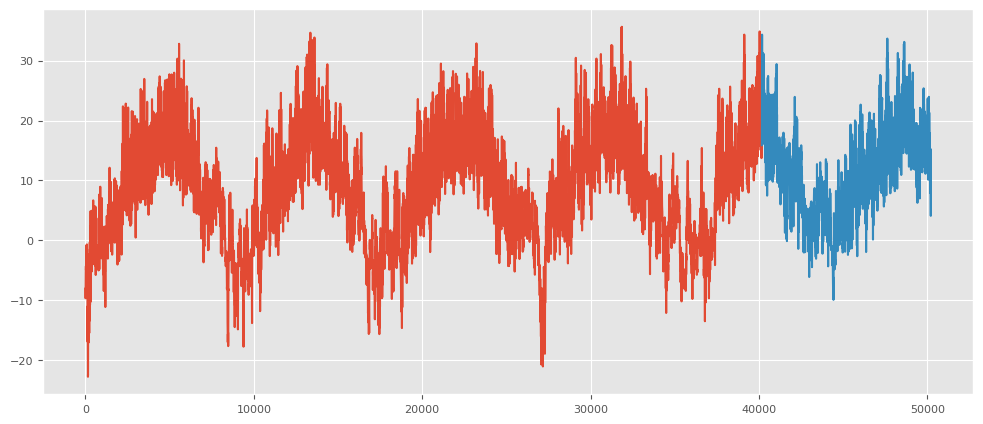

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

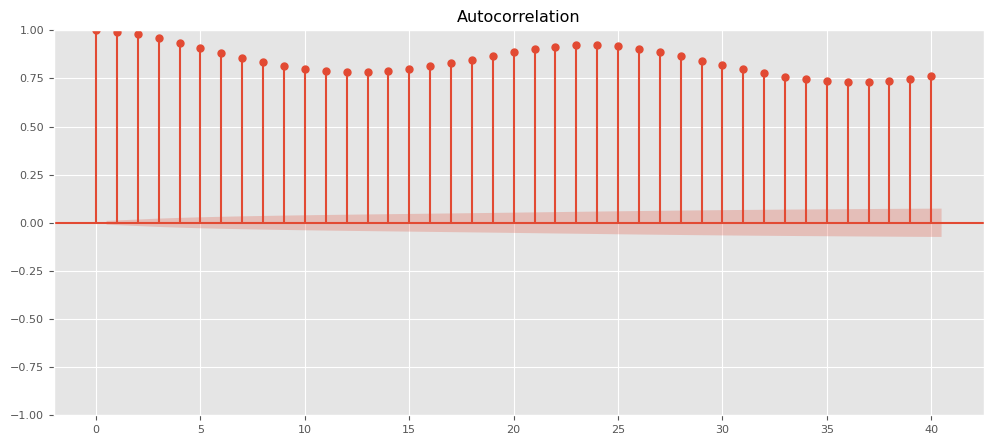

<Figure size 1200x500 with 0 Axes>

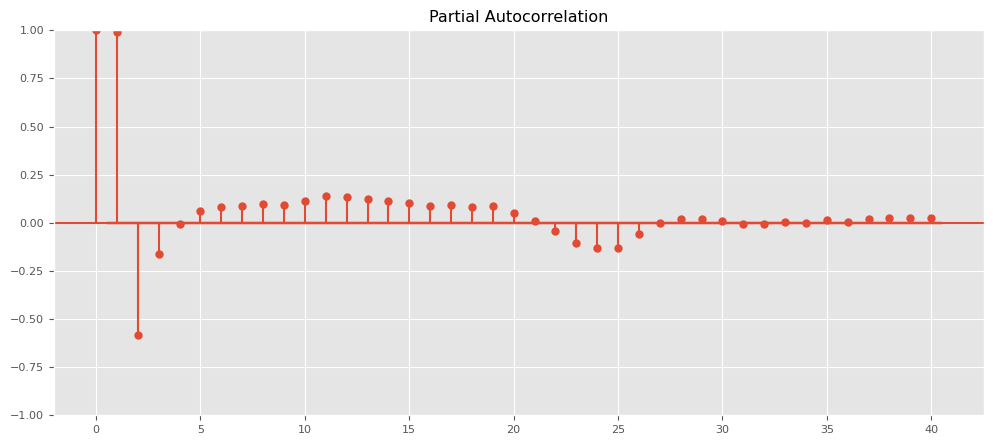

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EEMD

<Axes: xlabel='Time (samples)'>

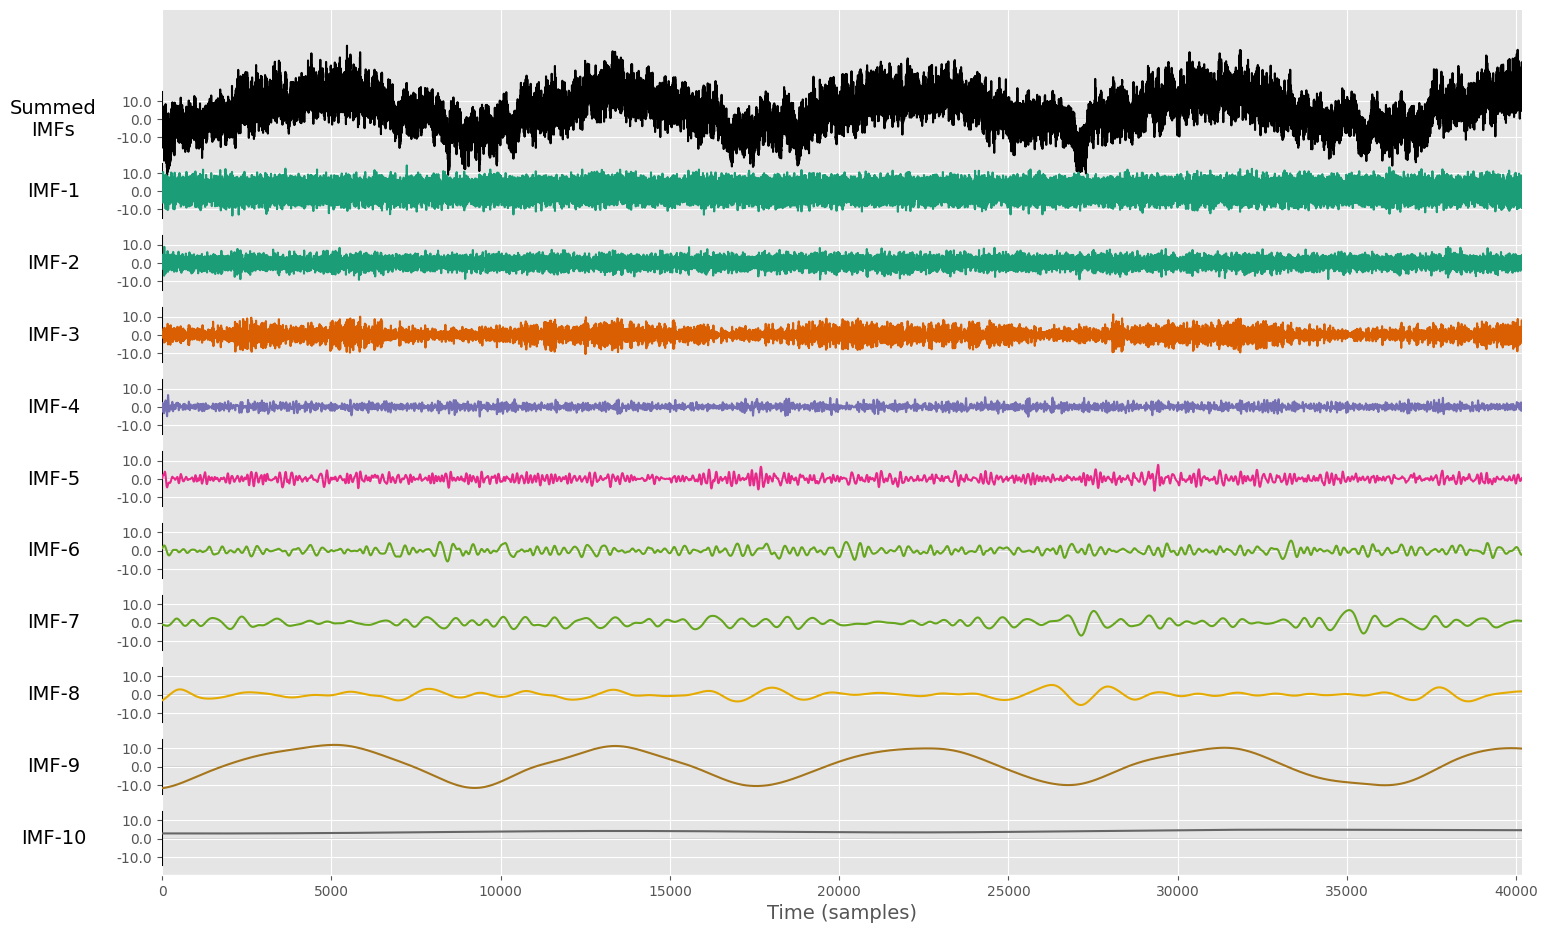

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,2.334576,0.074945,0.640883,-2.522252,0.374323,1.428812,-0.959113,-3.122512,-11.862584,2.796941
1,3.178034,-0.103603,0.847600,-2.332116,0.426277,1.454121,-0.969859,-3.113069,-11.860237,2.796901
2,-2.944270,1.303392,1.042666,-2.056074,0.483664,1.479922,-0.980448,-3.103563,-11.857879,2.796860
3,-1.326646,3.140081,1.128645,-1.709153,0.546266,1.506207,-0.990883,-3.093995,-11.855508,2.796820
4,1.834119,3.049659,1.022201,-1.308061,0.613785,1.532967,-1.001167,-3.084365,-11.853126,2.796780
...,...,...,...,...,...,...,...,...,...,...
40174,-5.784779,-0.671944,-0.838748,2.427605,0.454250,-2.257970,0.942689,1.771285,9.865853,4.565407
40175,1.037366,-2.496965,-2.064789,2.410039,0.469235,-2.253837,0.942214,1.770916,9.864375,4.565405
40176,3.611215,-2.535350,-2.923978,2.366508,0.482418,-2.249031,0.941787,1.770531,9.862893,4.565402
40177,-0.075223,-1.938557,-3.359069,2.299369,0.493770,-2.243565,0.941408,1.770131,9.861406,4.565399


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

lstm_1 = 128  # Aumento de neuronas en la primera capa LSTM
dropout = 0.5  # Aumento de la tasa de Dropout
lstm_2 = 64  # Aumento de neuronas en la segunda capa LSTM
dense_1 = 32  # Aumento de neuronas en la capa densa
dense_2 = 1

epochs = 50  # Aumento de épocas para un mejor entrenamiento
patience = 6  # Paciencia para EarlyStopping
test_length = len(test)

# EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [13]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SRV = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SRV.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SRV.predict(np.array(df_test))

imf3_eemd_SRV = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SRV.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SRV.predict(np.array(df_test))

imf4_eemd_SRV = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SRV.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SRV.predict(np.array(df_test))

imf5_eemd_SRV = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SRV.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SRV.predict(np.array(df_test))

imf6_eemd_SRV = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SRV.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SRV.predict(np.array(df_test))

# # IMF 5
# imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
# imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

# model5 = Sequential()
# model5.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
# model5.add(Dropout(dropout))
# model5.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model5.add(Dropout(dropout))  # Añadir Dropout adicional
# model5.add(Dense(dense_1, activation='relu'))
# model5.add(Dense(dense_2))
# model5.compile(optimizer='adam', loss='mse')
# model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
# imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# # IMF 6
# imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
# imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

# model6 = Sequential()
# model6.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
# model6.add(Dropout(dropout))
# model6.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model6.add(Dropout(dropout))  # Añadir Dropout adicional
# model6.add(Dense(dense_1, activation='relu'))
# model6.add(Dense(dense_2))
# model6.compile(optimizer='adam', loss='mse')
# model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
# imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

model7 = Sequential()
model7.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dropout(dropout))
model7.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model7.add(Dropout(dropout))  # Añadir Dropout adicional
model7.add(Dense(dense_1, activation='relu'))
model7.add(Dense(dense_2))
model7.compile(optimizer='adam', loss='mse')
model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

# IMF 8
imf8_eemd_lstm_X, imf8_eemd_lstm_y, scaler8 = prepare_data(imf_eemd_df['imf_eemd_8'])
imf8_eemd_lstm_X = imf8_eemd_lstm_X.reshape((imf8_eemd_lstm_X.shape[0], 1, imf8_eemd_lstm_X.shape[1]))

model8 = Sequential()
model8.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf8_eemd_lstm_X.shape[1], imf8_eemd_lstm_X.shape[2])))
model8.add(Dropout(dropout))
model8.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model8.add(Dropout(dropout))  # Añadir Dropout adicional
model8.add(Dense(dense_1, activation='relu'))
model8.add(Dense(dense_2))
model8.compile(optimizer='adam', loss='mse')
model8.fit(imf8_eemd_lstm_X, imf8_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
imf8_eemd_lstm_fc = model8.predict(imf8_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf8_eemd_lstm_fc = scaler8.inverse_transform(imf8_eemd_lstm_fc)

# IMF 9
imf9_eemd_lstm_X, imf9_eemd_lstm_y, scaler9 = prepare_data(imf_eemd_df['imf_eemd_9'])
imf9_eemd_lstm_X = imf9_eemd_lstm_X.reshape((imf9_eemd_lstm_X.shape[0], 1, imf9_eemd_lstm_X.shape[1]))

model9 = Sequential()
model9.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf9_eemd_lstm_X.shape[1], imf9_eemd_lstm_X.shape[2])))
model9.add(Dropout(dropout))
model9.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model9.add(Dropout(dropout))  # Añadir Dropout adicional
model9.add(Dense(dense_1, activation='relu'))
model9.add(Dense(dense_2))
model9.compile(optimizer='adam', loss='mse')
model9.fit(imf9_eemd_lstm_X, imf9_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
imf9_eemd_lstm_fc = model9.predict(imf9_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf9_eemd_lstm_fc = scaler9.inverse_transform(imf9_eemd_lstm_fc)

# # IMF 10
# imf10_eemd_lstm_X, imf10_eemd_lstm_y, scaler10 = prepare_data(imf_eemd_df['imf_eemd_10'])
# imf10_eemd_lstm_X = imf10_eemd_lstm_X.reshape((imf10_eemd_lstm_X.shape[0], 1, imf10_eemd_lstm_X.shape[1]))

# model10 = Sequential()
# model10.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf10_eemd_lstm_X.shape[1], imf10_eemd_lstm_X.shape[2])))
# model10.add(Dropout(dropout))
# model10.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model10.add(Dropout(dropout))  # Añadir Dropout adicional
# model10.add(Dense(dense_1, activation='relu'))
# model10.add(Dense(dense_2))
# model10.compile(optimizer='adam', loss='mse')
# model10.fit(imf10_eemd_lstm_X, imf10_eemd_lstm_y, epochs=epochs, verbose=0, validation_split=0.2, callbacks=[early_stopping])
# imf10_eemd_lstm_fc = model10.predict(imf10_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf10_eemd_lstm_fc = scaler10.inverse_transform(imf10_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [14]:
from statsmodels.tsa.arima.model import ARIMA

imf10_train = imf_eemd_df['imf_eemd_10'].values
imf10_eemd_ARIMA = ARIMA(imf10_train, order=(5, 1, 0))
imf10_eemd_ARIMA_fit = imf10_eemd_ARIMA.fit()
imf10_test = df_test.values
imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(imf10_test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


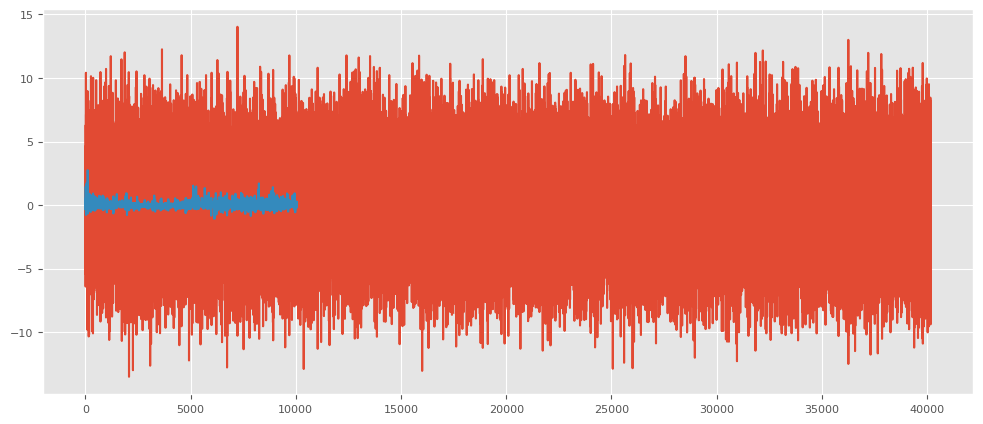

In [15]:
# plot imf1_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_1'])
plt.plot(imf1_eemd_SVR_fc)
plt.show()

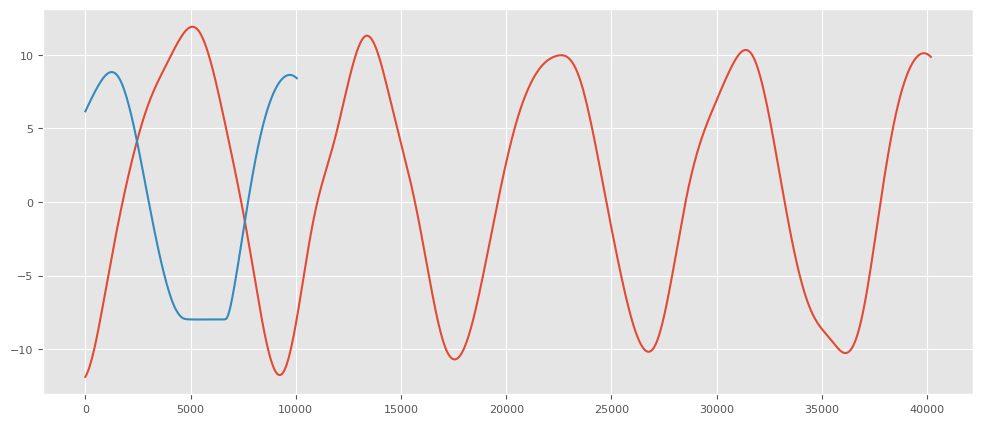

In [16]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_9'])
plt.plot(imf9_eemd_lstm_fc)
plt.show()

In [17]:
# # plot imf10_eemd_SVR_fc real vs predited values
# plt.plot(imf_eemd_df['imf_eemd_10'])
# plt.plot(imf10_eemd_ARIMA_fc)
# plt.show()

In [18]:
# imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
# imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
# imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
# imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
# imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
# imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)
imf8_eemd_lstm_fc_8 = imf8_eemd_lstm_fc.reshape(-1)
imf9_eemd_lstm_fc_9 = imf9_eemd_lstm_fc.reshape(-1)
# imf10_eemd_lstm_fc_10 = imf10_eemd_lstm_fc.reshape(-1)

In [19]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc, imf6_eemd_SVR_fc,
                imf7_eemd_lstm_fc_7, imf8_eemd_lstm_fc_8, imf9_eemd_lstm_fc_9, imf10_eemd_ARIMA_fc], axis = 0)

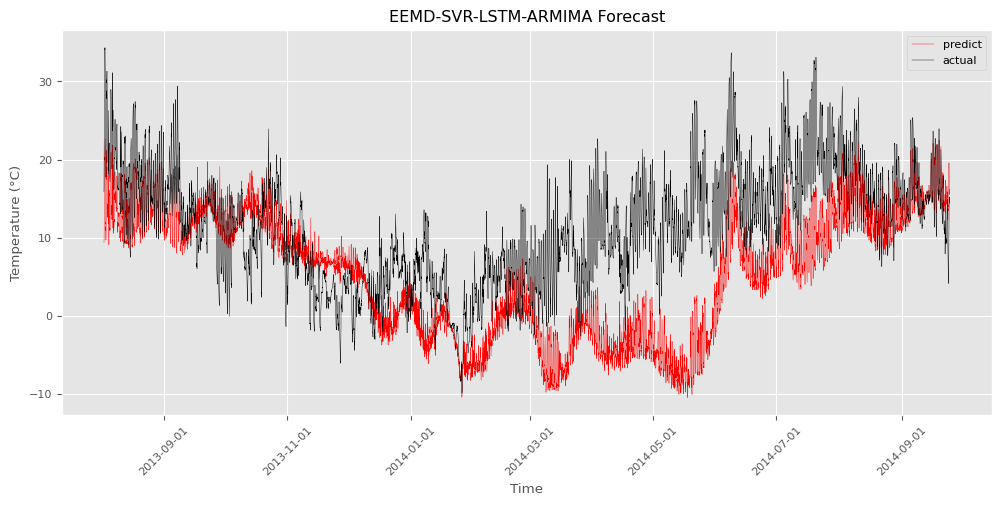

In [20]:
import matplotlib.dates as mdates
import pandas as pd

target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-SVR-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

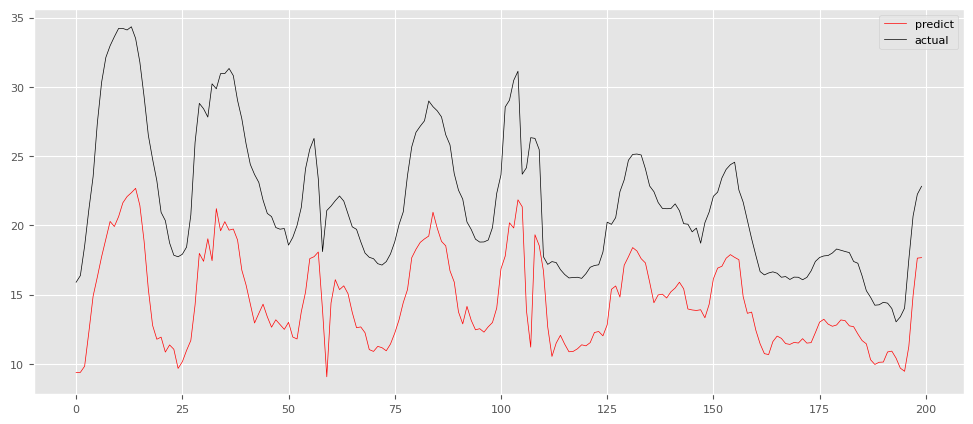

MSE = 83.0245247389416 
MAE = 7.175293899839365 
MAPE = 1840328191652.841


In [21]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [22]:
imf1_eemd_SVR_fc_train = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc_train = imf2_eemd_SRV.predict(np.array(df_train))
imf3_eemd_SVR_fc_train = imf3_eemd_SRV.predict(np.array(df_train))
imf4_eemd_SVR_fc_train = imf4_eemd_SRV.predict(np.array(df_train))
imf5_eemd_SVR_fc_train = imf5_eemd_SRV.predict(np.array(df_train))
imf6_eemd_SVR_fc_train = imf5_eemd_SRV.predict(np.array(df_train))

# # IMF 5
# imf5_eemd_lstm_fc_train = model5.predict(imf5_eemd_lstm_X).reshape(-1, 1)
# imf5_eemd_lstm_fc_train = scaler5.inverse_transform(imf5_eemd_lstm_fc_train)

# # IMF 6
# imf6_eemd_lstm_fc_train = model6.predict(imf6_eemd_lstm_X).reshape(-1, 1)
# imf6_eemd_lstm_fc_train = scaler6.inverse_transform(imf6_eemd_lstm_fc_train)

# IMF 7
imf7_eemd_lstm_fc_train = model7.predict(imf7_eemd_lstm_X).reshape(-1, 1)
imf7_eemd_lstm_fc_train = scaler7.inverse_transform(imf7_eemd_lstm_fc_train)

# IMF 8
imf8_eemd_lstm_fc_train = model8.predict(imf8_eemd_lstm_X).reshape(-1, 1)
imf8_eemd_lstm_fc_train = scaler8.inverse_transform(imf8_eemd_lstm_fc_train)

# IMF 9
imf9_eemd_lstm_fc_train = model9.predict(imf9_eemd_lstm_X).reshape(-1, 1)
imf9_eemd_lstm_fc_train = scaler9.inverse_transform(imf9_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [23]:
imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))

In [24]:
# imf5_eemd_lstm_fc_train = imf5_eemd_lstm_fc_train.reshape(-1)
# imf6_eemd_lstm_fc_train = imf6_eemd_lstm_fc_train.reshape(-1)
imf7_eemd_lstm_fc_train = imf7_eemd_lstm_fc_train.reshape(-1)
imf8_eemd_lstm_fc_train = imf8_eemd_lstm_fc_train.reshape(-1)
imf9_eemd_lstm_fc_train = imf9_eemd_lstm_fc_train.reshape(-1)
# imf10_eemd_lstm_fc_train = imf10_eemd_lstm_fc_train.reshape(-1)

In [25]:
imf1_eemd_SVR_fc_train_1 = imf1_eemd_SVR_fc_train[1:]
imf2_eemd_SVR_fc_train_2 = imf2_eemd_SVR_fc_train[1:]
imf3_eemd_SVR_fc_train_3 = imf3_eemd_SVR_fc_train[1:]
imf4_eemd_SVR_fc_train_4 = imf4_eemd_SVR_fc_train[1:]
imf5_eemd_SVR_fc_train_5 = imf5_eemd_SVR_fc_train[1:]
imf6_eemd_SVR_fc_train_6 = imf6_eemd_SVR_fc_train[1:]

imf10_eemd_ARIMA_fc_train_10 = imf10_eemd_ARIMA_fc_train[1:]

In [26]:
imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc_train_1, imf2_eemd_SVR_fc_train_2, imf3_eemd_SVR_fc_train_3,
                imf4_eemd_SVR_fc_train_4, imf5_eemd_SVR_fc_train_5, imf6_eemd_SVR_fc_train_6,
                imf7_eemd_lstm_fc_train, imf8_eemd_lstm_fc_train, imf9_eemd_lstm_fc_train, imf10_eemd_ARIMA_fc_train_10], axis = 0)

In [27]:
train = train[1:]

In [28]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

# Ajustar el método y la tolerancia
res1 = minimize(dummy1, 0, method='L-BFGS-B', 
                 options={'xatol': 1e-10, 'disp': True})

print(res1.x)

[3.58440385]


C:\Users\sevann radhak\AppData\Local\Temp\ipykernel_34756\899175815.py:10: OptimizeWarning: Unknown solver options: xatol
  res1 = minimize(dummy1, 0, method='L-BFGS-B',


In [29]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 53.773191916283345 
MAE = 5.685741710805273 
MAPE = 1373752416202.8645


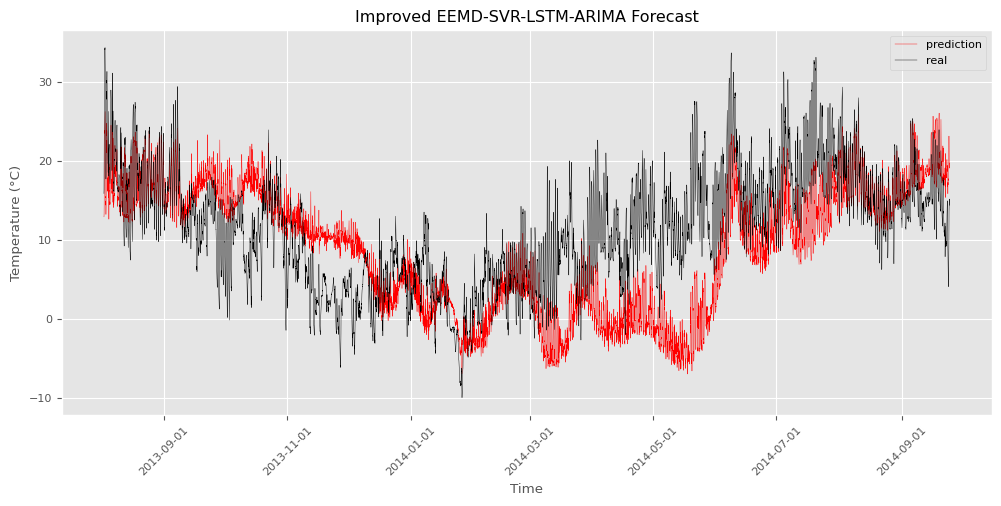

In [30]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR-LSTM-ARIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

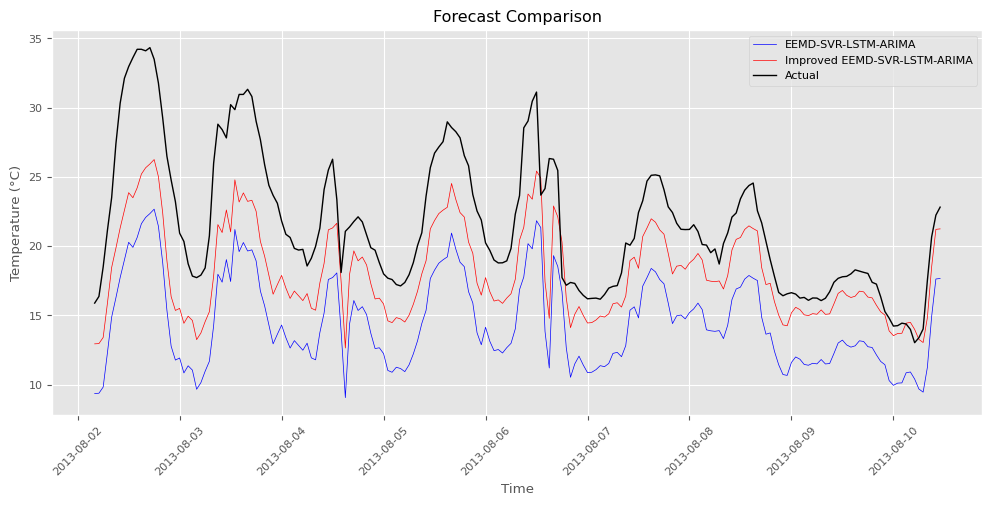

In [31]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-SVR-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-SVR-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()